<h1> Kaggle Competition - House Price Prediction</h1>

In [50]:
from __future__ import print_function
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math

from operator import itemgetter
from IPython.display import display, Image
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import xgboost as xgb

mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)

<h2>Data Preparation</h2>
Read data from the train data set

In [3]:
raw_data = pd.read_csv("train.csv",index_col=0)
raw_test = pd.read_csv("test.csv",index_col=0)

print(raw_data.head())
print("total number of training data is {}".format(len(raw_data)))

    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
Id                                    ...                             
1          Lvl    AllPub    Inside    ...            0    NaN   NaN   
2          Lvl    AllPub       FR2    ...            0    NaN   NaN   
3          Lvl    AllPub    Inside    ...            0    NaN   NaN   
4          Lvl    AllPub    Corner    ...            0    NaN   NaN   
5          Lvl    AllPub       FR2    ...            0    NaN   NaN   

   M

<h3>Outliers</h3>
Find the outlier of the data set. From the acknowledgement part of author, there's several outlier need to be removed. Investigate by plotting sale price vs gr liv area. Linear Regression is done for both before and after outlier removal.

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Total Number of training data is 1456


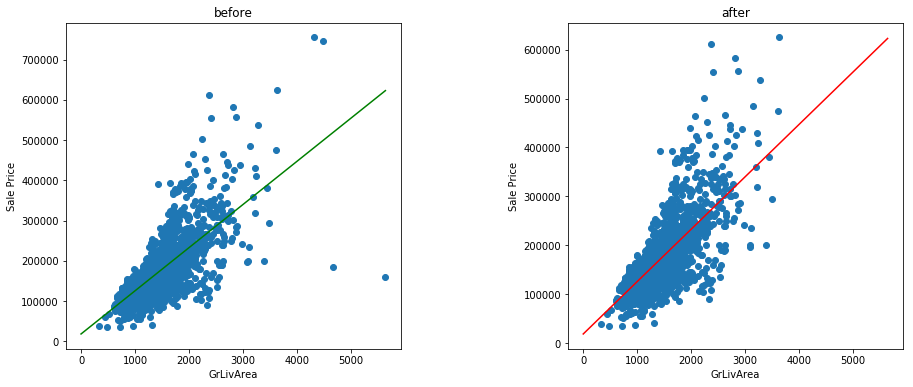

In [4]:
def plot_linearReg(_X,_y,label,color):
    _X = _X.values.reshape(-1,1)
    _y - _y.values
    _reg = LinearRegression().fit(_X,_y)
    _coef = _reg.coef_
    _intc = _reg.intercept_
    _x_toplot = np.linspace(0,max(_X),len(_X),dtype=float)
    _y_toplot = _intc + _coef*_x_toplot
    return plt.plot(_x_toplot,_y_toplot,color=color,label=label)

if any(pd.isnull(raw_data['GrLivArea'].values)):
    print("There's nan in GrLivArea")
else:
    fig = plt.figure(figsize=(15,6))
    fig.add_subplot(121,xlabel="GrLivArea",ylabel="Sale Price")
    plt.title("before")
    plt.scatter(raw_data['GrLivArea'],raw_data['SalePrice'])
    plot_linearReg(raw_data['GrLivArea'],raw_data['SalePrice'],'before remove','green')
    fig.add_subplot(122,xlabel="GrLivArea",ylabel="Sale Price")
    plt.title("after")
    plt.subplots_adjust(wspace=0.5)
    raw_data_clear = raw_data[raw_data['GrLivArea']<4000]
    plt.scatter(raw_data_clear['GrLivArea'],raw_data_clear['SalePrice'])
    plot_linearReg(raw_data['GrLivArea'],raw_data['SalePrice'],'after remove','red')

print("Total Number of training data is {}".format(len(raw_data_clear)))

<h3>Handling Missing Data</h3>
Next, I will proceed to investigate missing value on training and testing data. There are 2 ways of handling missing value. Imputing the missing value using some regression or delete the entire row. Missing value need to be done to both testing and training data for consistency.

Total Number of data is 2915
[('PoolQC', 2907), ('MiscFeature', 2810), ('Alley', 2717), ('Fence', 2345), ('FireplaceQu', 1420), ('LotFrontage', 486), ('GarageCond', 159), ('GarageQual', 159), ('GarageFinish', 159), ('GarageYrBlt', 159), ('GarageType', 157), ('BsmtExposure', 82), ('BsmtCond', 82), ('BsmtQual', 81), ('BsmtFinType2', 80), ('BsmtFinType1', 79), ('MasVnrType', 24), ('MasVnrArea', 23), ('MSZoning', 4), ('Functional', 2), ('BsmtHalfBath', 2), ('BsmtFullBath', 2), ('Utilities', 2), ('SaleType', 1), ('GarageArea', 1), ('GarageCars', 1), ('KitchenQual', 1), ('Electrical', 1), ('TotalBsmtSF', 1), ('BsmtUnfSF', 1), ('BsmtFinSF2', 1), ('BsmtFinSF1', 1), ('Exterior2nd', 1), ('Exterior1st', 1)]


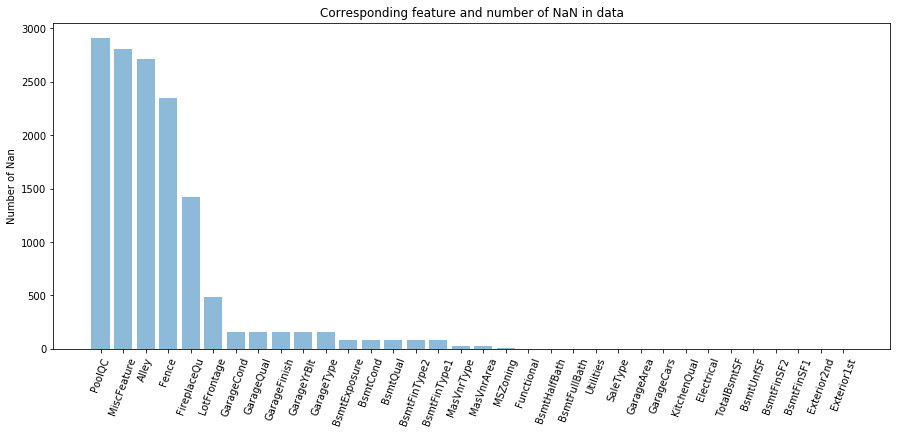

In [5]:
def plot_missing_fv(train,test,target):
    '''
    Visualize number of Nan in the missing future.
    input  : training and testing dataframe, target header to predict e.g. result, price etc.
    output : bar plot showing number of Nan for each feature and 
    '''
    train = train.drop(columns=target)
    _data = pd.concat([train,test])
    _headers = _data.columns.values.tolist()
    _nan_list = []
    for _header in _headers:
        _nan = _data[_header].isna().sum()
        if _nan != 0 :
            _nan_list.append((_header,_nan))
    _nan_list = list(reversed(sorted(_nan_list, key=itemgetter(1))))
    _to_plot = zip(*_nan_list)
    plt.figure(figsize=(15,6))
    plt.title("Corresponding feature and number of NaN in data")
    plt.bar(np.arange(len(_to_plot[0])),_to_plot[1], align='center', alpha=0.5)
    plt.xticks(np.arange(len(_to_plot[0])),_to_plot[0],rotation=70)
    plt.ylabel("Number of Nan")
    #print("Feature with nan value is {}".format(_nan_dict.keys()))
    print("Total Number of data is {}".format(len(_data)))
    print(_nan_list)

plot_missing_fv(raw_data_clear,raw_test,'SalePrice')

Based on the bar plot above, there's several point that worth noticing:
<ul>
<li>For feature with nan number less than 10, we can safely impute missing value with their mode. 
<li>Based on data description, these Nan in these feature ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu","GarageType",
"GarageFinish", "GarageQual", "GarageCond","BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1","BsmtFinType2", "MSSubClass",
"MasVnrType"] means that the feature doens't exist for the house. Hence we can fill all the nan with "None".
<li>For feature ("LotFrontage"), we can choose to impute nan values with the median of the houses of neighbourhood which data located with
<li>For the rest of the feature, we can impute all nan with 0
<ul>

In [6]:
data = pd.concat([raw_data_clear.drop(columns="SalePrice"),raw_test])

for col in ["MSZoning","Electrical","KitchenQual","Exterior1st","Exterior2nd","SaleType","Functional"]:
    data[col] = data[col].fillna(data[col].mode()[0])

for col in ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu","GarageType", "GarageFinish", 
            "GarageQual", "GarageCond","BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1","BsmtFinType2", 
            "MSSubClass", "MasVnrType"]:
    data[col] = data[col].fillna("None")

data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x : x.fillna(x.median()))

for col in ["GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
            "MasVnrArea","BsmtFullBath", "BsmtHalfBath"]:
    data[col] = data[col].fillna(0)

def check_nan_dataframe(df):
    nan_list = []
    for col in df.columns.tolist():
        if df[col].isna().sum() != 0:
            nan_list.append([col,df[col].isna().sum()])
    return print("Feature with nan left {}.".format(nan_list))

check_nan_dataframe(data)
print("Unique data within 'Utilities' feature is {}".format(data['Utilities'].unique()))

Feature with nan left [['Utilities', 2]].
Unique data within 'Utilities' feature is ['AllPub' 'NoSeWa' nan]


We will need to check the distribution of 'Utilities' feature. Countplot is a good way to do that.

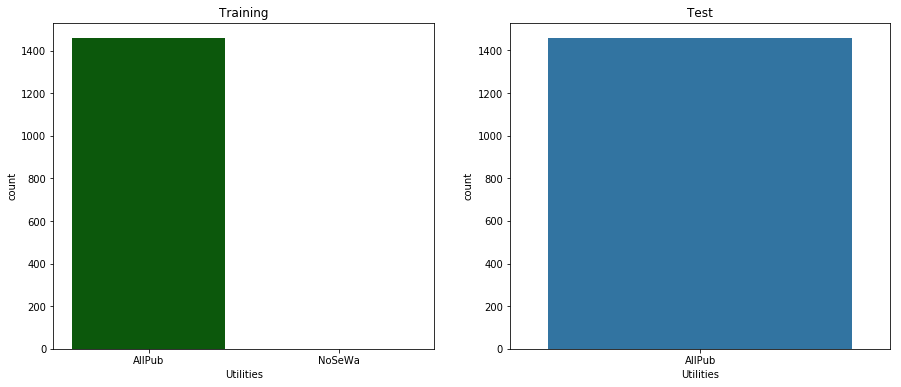

In [16]:
plt.subplots(figsize=(15,6))
plt.subplot(121)
g = sns.countplot(x="Utilities", data=raw_data, color="DarkGreen").set_title("Training")
plt.subplot(122)
g = sns.countplot(x="Utilities",data=raw_test).set_title("Test")

Above graph shows that the test data contains mostly utilties hence feature 'Utilities' is not useful in prediction. Then proceed to break up the data after handling missing data into training and testing data.

In [8]:
data = data.drop(columns='Utilities')
data = data.reset_index()
train = data.loc[(data["Id"] >= 1) & (data["Id"] <= 1460)]
train = train.set_index('Id',inplace=False)
train = train.assign(SalePrice=raw_data_clear['SalePrice'])
check_nan_dataframe(train)
print("Train data shape is {}".format(train.values.shape))
test = data.loc[data["Id"] > 1460]
check_nan_dataframe(test)
print("Test data shape is {}".format(test.values.shape))

Feature with nan left [].
Train data shape is (1456, 79)
Feature with nan left [].
Test data shape is (1459, 79)


<h2>Data Analysis</h2>
<h3>Correlation Matrix</h3>

Next, I proceed to do Data Analysis. 
First started with Correlation Matrix.


Sorted Top correlated feature are ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', 'WoodDeckSF', '2ndFlrSF', 'HalfBath', 'LotArea', 'GarageYrBlt', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch', 'MoSold', '3SsnPorch', 'PoolArea', 'BsmtFinSF2', 'MiscVal', 'YrSold', 'LowQualFinSF', 'BsmtHalfBath', 'OverallCond', 'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr']


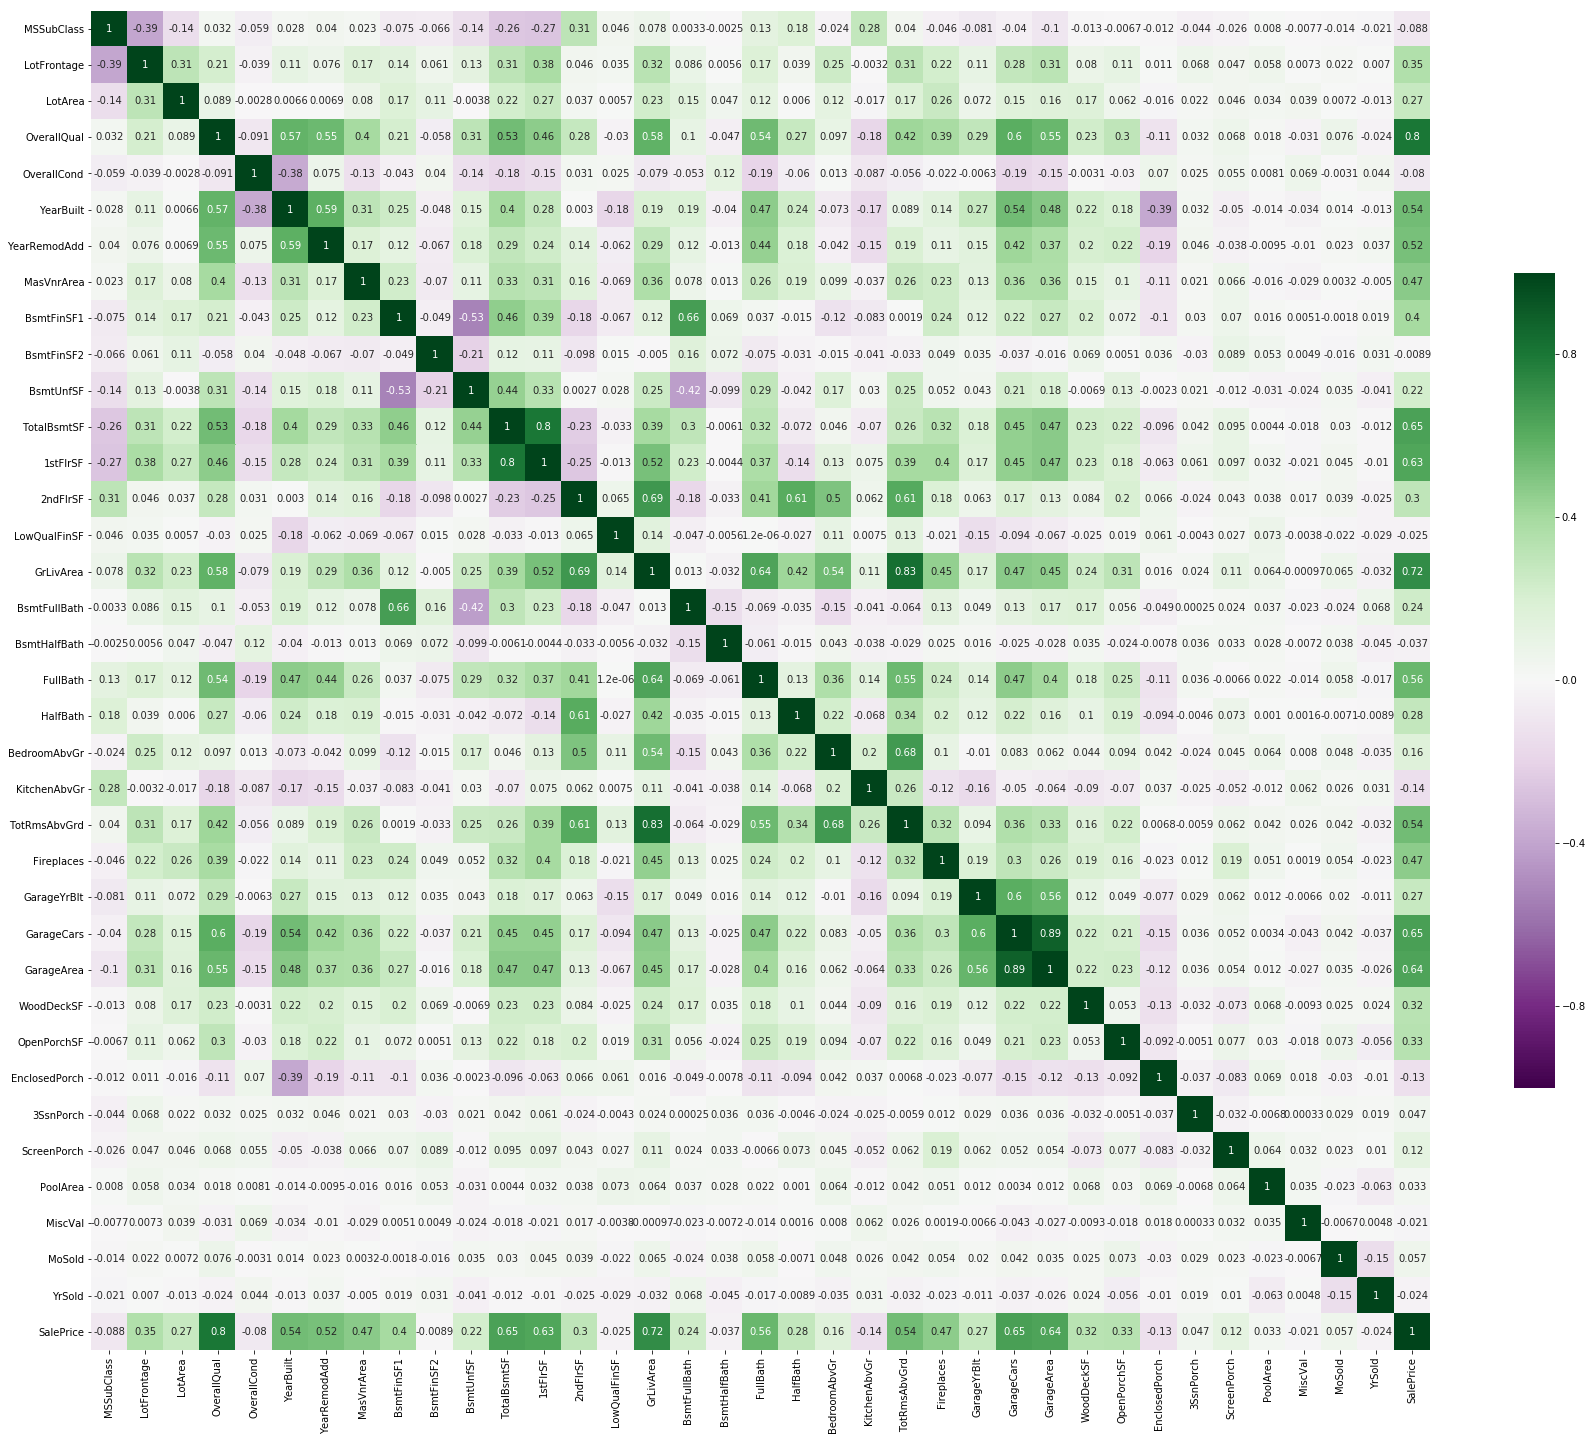

In [43]:
def plot_corr(df,size=30):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    topfv = corr.iloc[:,-1]
    topfv = list(reversed(sorted(list(zip(topfv,topfv.index)),key=itemgetter(0))))
    topfv = [ x[1] for x in topfv]
    plt.subplots(figsize=(size, size))
    cmap = sns.diverging_palette(150, 250, as_cmap=True)
    sns.heatmap(corr, cmap='PRGn', vmax=1, vmin=-1, center=0, square=True, linewidth=0, cbar_kws={'shrink':0.5}, annot=True)
    return topfv

top_header = plot_corr(train)
print("Sorted Top correlated feature are {}".format(top_header))

Correlation matrix shows the correlation coefficients between each features, and more importantly it allows us to know which are the highly influencing features on Sale Price.
3 Main reason to compute the correlation matrix :
<ul>
<li>To summarize a large amount of data where the goal is to see patterns. 
<li>To input into other analyses. For example, people commonly use correlation matrixes as inputs for exploratory factor analysis, confirmatory factor analysis, structural equation models, and linear regression when excluding missing values pairwise.
<li>As a diagnostic when checking other analyses. For example, with linear regression a high amount of correlations suggests that the linear regression’s estimates will be unreliable.
<ul>

<h3>Feature Engineering </h3>
Based on the result of correlation matrix, I proceed to extract the complex non-linear relationship between high correlation features with respect to Sale Price.<br /> Top 15 Highly correlated features are :
<ul>
<li>OverallQual
<li>GrLivArea
<li>GarageCars
<li>TotalBsmtSF
<li>GarageArea
<li>1stFlrSF
<li>FullBath
<li>TotRmsAbvGrd
<li>MasVnrArea
<li>Fireplaces
<li>BsmtFinSF1
<li>LotFrontage
<li>OpenPorchSF
<li>WoodDeckSF
<li>2ndFlrSF

        
<br />From these 15 high correlated feature, polynomials transformation on feature can be done as additional features for data. Polynomial up to 3 degrees is done and reciprocal relationship is extracted.

In [46]:
def list_diff(list1, list2):
    c = set(list1).union(set(list2))
    d = set(list1).intersection(set(list2))
    return list (c-d)

top15fv = list_diff(top_header,['SalePrice','YearBuilt', 'YearRemodAdd'])[0:15]

for deg in [2,3]:
    for fv in top15fv:
        data[fv+'-'+str(deg)] = data[fv]**deg

for hd in top15fv:
    data[hd+'-'+'Sq'] = np.sqrt(data[hd])

print(data.shape)

(2915, 124)


Now, I will proceed to analyses each feature that has non numbers value.

In [48]:
non_floats = []
for col in data:
    if data[col].dtypes != 'float64':
        non_floats.append(col)
print(non_floats)

['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', '3SsnPorch-2', 'OpenPorchSF-2', '2ndFlrSF-2', 'HalfBath-2', 'OverallCond-2', 'LotArea-2

We can see clearly that basement height correlate positively with sale price. From strip plot, we can see that most house have Typical and Good grade basement height, we can proceed to label categorical data of BsmtQual manually.


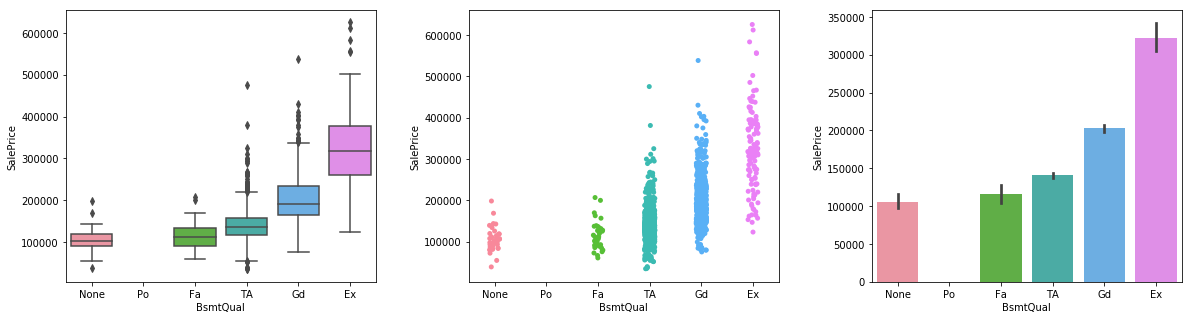

In [72]:
def categorical_plot(fv,order,tg='SalePrice'):
    
    plt.subplots(figsize=(20,5))
    plt.subplot(131)
    sns.boxplot(x=fv,y=tg,data=train,order=order)
    plt.subplot(132)
    sns.stripplot(x=fv,y=tg,data=train,size=5,jitter=True,order=order)
    plt.subplot(133)
    sns.barplot(x=fv,y=tg,data=train,order=order)
    plt.subplots_adjust(wspace=0.3)

T1map = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
T1order = ['None','Po','Fa','TA','Gd','Ex']
T2map = {}
T2order = ['No','Mn','Av','Gd']
T3order = ['Unf','LwQ','Rec','BLQ','ALQ','GLQ']
#T3order = 
#order=['NA','Po','Fa','TA','Gd','Ex']

categorical_plot('BsmtQual',T1order)
print("We can see clearly that basement height correlate positively with sale price. \
From strip plot, we can see that most house have Typical and Good grade basement height, \
we can proceed to label categorical data of BsmtQual manually.")
#categorical_plot('BsmtCond',T1order)
#categorical_plot('BsmtExposure',T2order)
#categorical_plot('BsmtFinType1',T3order)
#categorical_plot('BsmtFinType2',T3order)


<h4>Basement Height (BsmtQual) </h4>
<p>We can see clearly that basement height correlate positively with sale price. From strip plot, we can see that most house have Typical and Good grade basement height, we can proceed to label categorical data of BsmtQual manually.</p>


In [ ]:
#raw_data = raw_data.replace(np.nan,"not available", regex=True)
le = LabelEncoder()
le_columns = ['MSZoning','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
            'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
            'Heating','Electrical','GarageType','MiscFeature','SaleType','SaleCondition']

def categoricalLabelling (df, cols):
    for c in cols:
        if any(pd.isnull(df[c].values)):
            df[c] = df[c].replace(np.nan,"not available", regex=True)
        if df[c].dtypes == 'object':
            data_cols = df[c]
            #print(data_cols)
            #print(type(data_cols))
            le.fit(data_cols.values)
            #print(data_cols.values)
            #print(type(data_cols.values))
            df[c]=le.transform(df[c])
    return df

Indicator_Dict = {'LotShape':{'Reg':3,'IR1':2,'IR2':1,'IR3':0},
                  'LandContour':{'Lvl':3,'Bnk':2,'HLS':1,'Low':0},
                  'Utilities':{'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0},
                  'LandSlope':{'Gtl':2,'Mod':1,'Sev':0},
                  'ExterQual':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0},
                  'ExterCond':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0},
                  'BsmtQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.nan:0},
                  'BsmtCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.nan:0},
                  'BsmtExposure':{'Gd':4,'Av':3,'Mn':2,'No':1,np.nan:0},
                  'BsmtFinType1':{'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,np.nan:0},
                  'BsmtFinType2':{'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,np.nan:0},
                  'HeatingQC':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0},
                  'CentralAir':{'N':0,'Y':1},
                  'Street':{'Grvl':0,'Pave':1},
                  'Alley':{'Grvl':1,'Pave':2,np.nan:0},
                  'KitchenQual':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0},
                  'Functional':{'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0},
                  'FireplaceQu':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.nan:0},
                  'GarageFinish':{'Fin':3,'RFn':2,'Unf':1,np.nan:0},
                  'GarageQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.nan:0},
                  'GarageCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.nan:0},
                  'PavedDrive':{'Y':2,'P':1,'N':0},
                  'PoolQC':{'Ex':4,'Gd':3,'TA':2,'Fa':1,np.nan:0},
                  'Fence':{'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,np.nan:0}}            
        
def qualitativeLabelling (df,cols,indicator):
    for c in cols:
        df[c] = df[c].replace(indicator[c])
    return df
        
ql_columns = Indicator_Dict.keys()

raw_data = categoricalLabelling(raw_data,le_columns)
#raw_data.to_csv("encoded.csv")
raw_data = qualitativeLabelling(raw_data,ql_columns,Indicator_Dict)
#raw_data.to_csv("encoded1.csv")

for col  in raw_data.columns.values:
    raw_data[col] = raw_data[col].replace(np.nan,0,regex=True)

if raw_data.isnull().any().any() :
    print("There's Nan in df, please check")


In [ ]:
def get_feature_target(df):
    _fv_df = df[feature_to_use].values
    _tg_df = df[target_to_pd].values
    return _fv_df,_tg_df

def list_diff(list1, list2):
    c = set(list1).union(set(list2))
    d = set(list1).intersection(set(list2))
    return list (c-d)

def get_feature_target(df):
    _fv_df = df[fv_header].values
    _tg_df = df[tg_header].values
    return _fv_df,_tg_df

def minmax_feature_scaler(X):
    '''
    Return scaled feature for regression
    X : unscaled nparray feature
    RETURN scaled feature
    '''
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    rescaled = scaler.fit_transform(X)
    return rescaled

fv_header = list_diff(raw_data.columns.tolist(),['SalePrice'])
tg_header = ['SalePrice']
X, y = get_feature_target(raw_data)
X_scaled = minmax_feature_scaler(X)

In [ ]:
print (X.shape)
print (y.shape)